In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

In [55]:
apt_price = pd.read_csv('../geocording_input/아파트_매매_실거래가_지오코딩_joined.csv')
apt_rent = pd.read_csv('../geocording_input/아파트_전월세_실거래가_지오코딩_joined.csv')
yunlip_price = pd.read_csv('../geocording_input/연립다세대_매매_실거래가_지오코딩_joined.csv')
yunlip_rent = pd.read_csv('../geocording_input/연립다세대_전월세_실거래가_지오코딩_joined.csv')
office_price = pd.read_csv('../geocording_input/오피스텔_매매_실거래가_지오코딩_joined.csv')
office_rent = pd.read_csv('../geocording_input/오피스텔_전월세_실거래가_지오코딩_joined.csv')
dan_price = pd.read_csv('../geocording_input/단독다가구_매매_실거래가_지오코딩_joined.csv')
dan_rent = pd.read_csv('../geocording_input/단독다가구_전월세_실거래가_지오코딩_joined.csv')
apt_lot = pd.read_csv('../geocording_input/분양권_실거래가_지오코딩_joined.csv')

# 아파트 매매 실거래가 분석

## 아파트의 매매 가격의 측정 기준으로 단지명과 층을 설정함

In [56]:
apt_price['층'] = apt_price['층'].astype('str')
apt_price['단지명_층'] = apt_price['단지명'] + ' ' + apt_price['층'] +'층'

## 아파트의 가격 추이를 보기 위해서 평당 가격을 측정한다

In [57]:
apt_price_price = []
for i in apt_price['거래금액(만원)'] :
    apt_price_price.append(i.replace(',',''))
apt_price['거래금액(만원)'] = apt_price_price
apt_price['거래금액(만원)'] = apt_price['거래금액(만원)'].astype('float')

- 전용 면적당 가격에 3.3 을 곱하여 평당 가격을 만들어 줍니다

In [58]:
apt_price['전용면적당_가격'] = apt_price['거래금액(만원)'] * 10000 / apt_price['전용면적(㎡)'] * 3.3

apt_price_diff = apt_price.groupby('단지명_층')[['전용면적당_가격','ADM_DR_NM']].agg(['first','last']).stack().reset_index()
apt_price_diff.columns = ['단지명_층','firt_last','금액','해당_동']

aa = apt_price.groupby('단지명_층')[['전용면적당_가격','ADM_DR_NM']].agg(['first']).stack().reset_index()

In [59]:
name = []
price_diff = []
location = []
per = []
for i in range(apt_price_diff.shape[0]-1) :
    if apt_price_diff['단지명_층'][i] == apt_price_diff['단지명_층'][i+1] :
        name.append(apt_price_diff['단지명_층'][i])
        price_diff.append(apt_price_diff['금액'][i+1] - apt_price_diff['금액'][i])
        location.append(apt_price_diff['해당_동'][i])
        per.append(100 * (apt_price_diff['금액'][i+1] - apt_price_diff['금액'][i])/apt_price_diff['금액'][i])
        
apt_price_final = pd.DataFrame({'단지명_층' : name,
              '해당_동' : location,
            '금액차이' : price_diff,
            '금액차이비율' : per})

In [60]:
apt_price_final_loc = apt_price_final.groupby('해당_동')[['금액차이']].mean().reset_index()

minimum = apt_price['ADM_DR_NM'].value_counts().reset_index()
zero_value = []

for i in range(len(minimum)) :
    if minimum['ADM_DR_NM'][i] <= 1:
        zero_value.append(minimum['index'][i])
        
if len(zero_value) > 0 :
    zero_value = pd.DataFrame({'해당_동' : zero_value,
                 '금액차이' : 0})
    apt_price_final_loc = apt_price_final_loc.append(zero_value)
else :
    pass

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

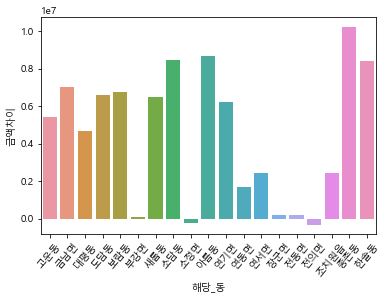

In [61]:
sns.barplot(apt_price_final_loc['해당_동'], apt_price_final_loc['금액차이'])
plt.xticks(rotation = 50)

## 비율차이

In [62]:
apt_price_final_loc = apt_price_final.groupby('해당_동')['금액차이비율'].mean().reset_index()

minimum = apt_price['ADM_DR_NM'].value_counts().reset_index()
zero_value = []

for i in range(len(minimum)) :
    if minimum['ADM_DR_NM'][i] <= 1:
        zero_value.append(minimum['index'][i])
        
if len(zero_value) > 0 :
    zero_value = pd.DataFrame({'해당_동' : zero_value,
                 '금액차이비율' : 0})
    apt_price_final_loc = apt_price_final_loc.append(zero_value)
else :
    pass

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

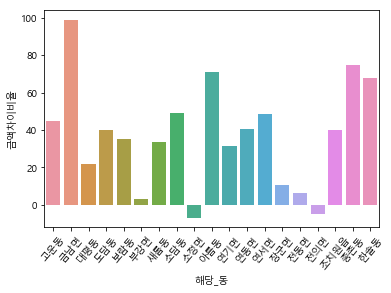

In [63]:
sns.barplot(apt_price_final_loc['해당_동'], apt_price_final_loc['금액차이비율'])
plt.xticks(rotation = 50)

# 아파트 전월세 실거래가 분석

## 법정 전월세 전환율을 사용하여 전세가격 추이 확인
#### 법정 전월세 전환율이 2020년9월을 기준으로 4%에서 2.5%로
#### 하락하였다 이에 따라 2020년9월 이전에 데이터 들은 4%로 계산
#### 이후의 데이터는 2.5%로 계산 하였다

In [64]:
apt_rent = apt_rent.reset_index(drop = True)

In [65]:
apt_rent_dep = []
for i in apt_rent['보증금(만원)'] :
    apt_rent_dep.append(i.replace(',','',))
apt_rent['보증금(만원)'] = apt_rent_dep
apt_rent['보증금(만원)'] = apt_rent['보증금(만원)'].astype('int')

In [66]:
rent_price = []
for i in range(apt_rent.shape[0]) :
    if apt_rent['계약년월'][i] <= 202009 :
        if apt_rent['전월세구분'][i] == '월세' :
            rent_price.append(apt_rent['월세(만원)'][i]*12*25 + apt_rent['보증금(만원)'][i])
        else :
            rent_price.append(apt_rent['보증금(만원)'][i])
    else :
        if apt_rent['전월세구분'][i] == '월세' :
            rent_price.append(apt_rent['월세(만원)'][i]*12*40 + apt_rent['보증금(만원)'][i])
        else :
            rent_price.append(apt_rent['보증금(만원)'][i])
apt_rent['책정금액'] = rent_price

## 금액 변동 확인

### 가격 책정을 위해 단지명과 층으로 나눈다

In [67]:
apt_rent['층'] = apt_rent['층'].astype('str')
apt_rent['단지명_층'] = apt_rent['단지명'] + ' ' + apt_rent['층'] +'층'


In [68]:
apt_rent['전용면적당_가격'] = apt_rent['책정금액'] * 10000 / apt_rent['전용면적(㎡)'] *3.3
apt_rent_diff = apt_rent.groupby('단지명_층')[['전용면적당_가격','ADM_DR_NM']].agg(['first','last']).stack().reset_index()
apt_rent_diff.columns = ['단지명_층','firt_last','금액','해당_동']

In [69]:
name = []
price_diff = []
location = []
per = []
for i in range(apt_rent_diff.shape[0]-1) :
    if apt_rent_diff['단지명_층'][i] == apt_rent_diff['단지명_층'][i+1] :
        name.append(apt_rent_diff['단지명_층'][i])
        price_diff.append(apt_rent_diff['금액'][i+1] - apt_rent_diff['금액'][i])
        location.append(apt_rent_diff['해당_동'][i])
        per.append(100 * (apt_rent_diff['금액'][i+1] - apt_rent_diff['금액'][i])/apt_rent_diff['금액'][i])
        
apt_rent_final = pd.DataFrame({'단지명_층' : name,
              '해당_동' : location,
            '금액차이' : price_diff,
            '금액차이비율' : per})
        


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

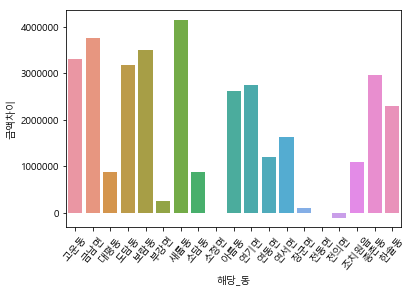

In [70]:
apt_rent_final_loc = apt_rent_final.groupby('해당_동')['금액차이'].mean().reset_index()
sns.barplot(apt_rent_final_loc['해당_동'], apt_rent_final_loc['금액차이'])
plt.xticks(rotation = 50)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

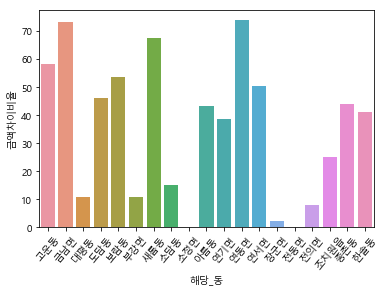

In [71]:
apt_rent_final_loc = apt_rent_final.groupby('해당_동')['금액차이비율'].mean().reset_index()
sns.barplot(apt_rent_final_loc['해당_동'], apt_rent_final_loc['금액차이비율'])
plt.xticks(rotation = 50)

# 연립다세대_가격 변동 추이

In [72]:
price = []
for i in yunlip_price['거래금액(만원)'] :
    price.append(i.replace(',',''))
yunlip_price['거래금액(만원)'] = price
yunlip_price['거래금액(만원)'] = yunlip_price['거래금액(만원)'].astype('int')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

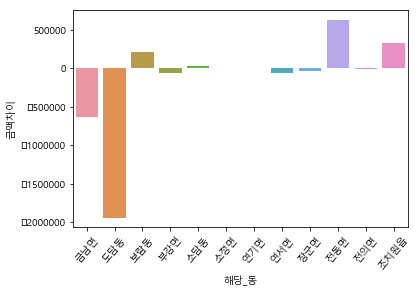

In [73]:
yunlip_price['층'] = yunlip_price['층'].astype('str')
yunlip_price['건물명_층'] = yunlip_price['건물명'] + ' ' + yunlip_price['층'] +'층'
yunlip_price['전용면적당_가격'] = yunlip_price['거래금액(만원)'] * 10000 / yunlip_price['전용면적(㎡)'] * 3.3
yunlip_price_diff = yunlip_price.groupby('건물명_층')[['전용면적당_가격','ADM_DR_NM']].agg(['first','last']).stack().reset_index()
yunlip_price_diff.columns = ['건물명_층','firt_last','금액','해당_동']
name = []
price_diff = []
location = []
per = []
for i in range(yunlip_price_diff.shape[0]-1) :
    if yunlip_price_diff['건물명_층'][i] == yunlip_price_diff['건물명_층'][i+1] :
        name.append(yunlip_price_diff['건물명_층'][i])
        price_diff.append(yunlip_price_diff['금액'][i+1] - yunlip_price_diff['금액'][i])
        location.append(yunlip_price_diff['해당_동'][i])
        per.append(100 * (yunlip_price_diff['금액'][i+1] - yunlip_price_diff['금액'][i])/yunlip_price_diff['금액'][i])
        
yunlip_price_final = pd.DataFrame({'단지명_층' : name,
              '해당_동' : location,
            '금액차이' : price_diff,
            '금액차이비율' : per})
        
yunlip_price_final_loc = yunlip_price_final.groupby('해당_동')['금액차이'].mean().reset_index()
sns.barplot(yunlip_price_final_loc['해당_동'], yunlip_price_final_loc['금액차이'])
plt.xticks(rotation = 50)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

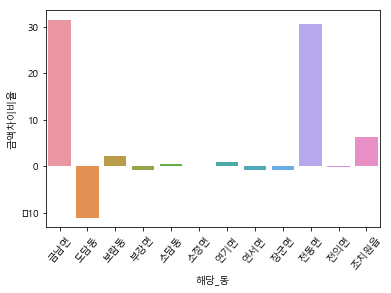

In [74]:
yunlip_price_final_loc = yunlip_price_final.groupby('해당_동')['금액차이비율'].mean().reset_index()
sns.barplot(yunlip_price_final_loc['해당_동'], yunlip_price_final_loc['금액차이비율'])
plt.xticks(rotation = 50)

## 연립다세대 전월세

In [75]:
yunlip_rent_dep = []
for i in yunlip_rent['보증금(만원)'] :
    yunlip_rent_dep.append(i.replace(',',''))
yunlip_rent['보증금(만원)'] = yunlip_rent_dep
yunlip_rent['보증금(만원)'] = yunlip_rent['보증금(만원)'].astype('int')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

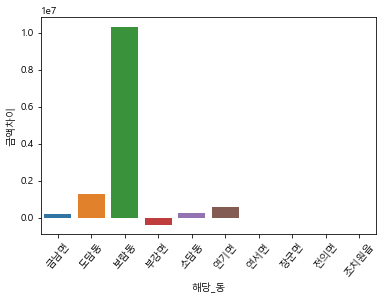

In [76]:
rent_price = []
for i in range(yunlip_rent.shape[0]) :
    if yunlip_rent['계약년월'][i] <= 202009 :
        if yunlip_rent['전월세구분'][i] == '월세' :
            rent_price.append(yunlip_rent['월세(만원)'][i]*12*25 + yunlip_rent['보증금(만원)'][i])
        else :
            rent_price.append(yunlip_rent['보증금(만원)'][i])
    else :
        if yunlip_rent['전월세구분'][i] == '월세' :
            rent_price.append(yunlip_rent['월세(만원)'][i]*12*40 + yunlip_rent['보증금(만원)'][i])
        else :
            rent_price.append(yunlip_rent['보증금(만원)'][i])
yunlip_rent['책정금액'] = rent_price
yunlip_rent['층'] = yunlip_rent['층'].astype('str')
yunlip_rent['건물명_층'] = yunlip_rent['건물명'] + ' ' + yunlip_rent['층'] +'층'
yunlip_rent['전용면적당_가격'] = yunlip_rent['책정금액'] * 10000 / yunlip_rent['전용면적(㎡)'] * 3.3
yunlip_rent_diff = yunlip_rent.groupby('건물명_층')[['전용면적당_가격','ADM_DR_NM']].agg(['first','last']).stack().reset_index()
yunlip_rent_diff.columns = ['건물명_층','firt_last','금액','해당_동']
name = []
price_diff = []
location = []
per = []
for i in range(yunlip_rent_diff.shape[0]-1) :
    if yunlip_rent_diff['건물명_층'][i] == yunlip_rent_diff['건물명_층'][i+1] :
        name.append(yunlip_rent_diff['건물명_층'][i])
        price_diff.append(yunlip_rent_diff['금액'][i+1] - yunlip_rent_diff['금액'][i])
        location.append(yunlip_rent_diff['해당_동'][i])
        per.append(100 * (yunlip_rent_diff['금액'][i+1] - yunlip_rent_diff['금액'][i])/yunlip_rent_diff['금액'][i])
        
yunlip_rent_final = pd.DataFrame({'단지명_층' : name,
              '해당_동' : location,
            '금액차이' : price_diff,
            '금액차이비율' : per})
        
yunlip_rent_final_loc = yunlip_rent_final.groupby('해당_동')['금액차이'].mean().reset_index()
sns.barplot(yunlip_rent_final_loc['해당_동'], yunlip_rent_final_loc['금액차이'])
plt.xticks(rotation = 50)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

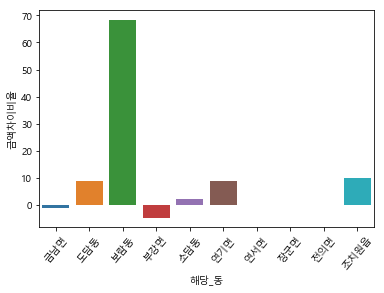

In [77]:
yunlip_rent_final_loc = yunlip_rent_final.groupby('해당_동')['금액차이비율'].mean().reset_index()
sns.barplot(yunlip_rent_final_loc['해당_동'], yunlip_rent_final_loc['금액차이비율'])
plt.xticks(rotation = 50)

# 오피스텔 매매 실거래가

In [78]:
office_price.columns

Index(['X', 'Y', '계약년월', '계약일', '시군구', '본번', '부번', '단지명', '전용면적(㎡)',
       '거래금액(만원)', '층', '건축년도', '해제사유발생일', '주소', '입력주소', 'X.1', 'Y.1', 'CLSS',
       'PNU', '주소구분', '표준신주소', '표준구주소', '우편번호', 'ADM_DR_CD', 'ADM_DR_NM',
       '군집'],
      dtype='object')

In [79]:
office_price_price = []
for i in office_price['거래금액(만원)'] :
    office_price_price.append(i.replace(',',''))
office_price['거래금액(만원)'] = office_price_price
office_price['거래금액(만원)'] = office_price['거래금액(만원)'].astype('int')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

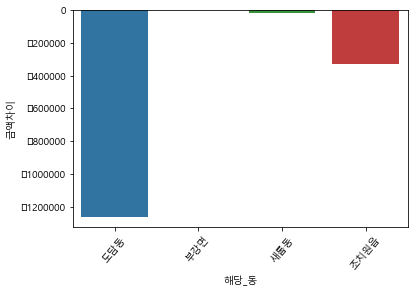

In [80]:
office_price['층'] = office_price['층'].astype('str')
office_price['단지명_층'] = office_price['단지명'] + ' ' + office_price['층'] +'층'
office_price['전용면적당_가격'] = office_price['거래금액(만원)'] * 10000 / office_price['전용면적(㎡)'] * 3.3
office_price_diff = office_price.groupby('단지명_층')[['전용면적당_가격','ADM_DR_NM']].agg(['first','last']).stack().reset_index()
office_price_diff.columns = ['단지명_층','first_last','금액','해당_동']
name = []
price_diff = []
location = []
per = []
for i in range(office_price_diff.shape[0]-1) :
    if office_price_diff['단지명_층'][i] == office_price_diff['단지명_층'][i+1] :
        name.append(office_price_diff['단지명_층'][i])
        price_diff.append(office_price_diff['금액'][i+1] - office_price_diff['금액'][i])
        location.append(office_price_diff['해당_동'][i])
        per.append(100 * (office_price_diff['금액'][i+1] - office_price_diff['금액'][i])/office_price_diff['금액'][i])
        
office_price_final = pd.DataFrame({'단지명_층' : name,
              '해당_동' : location,
            '금액차이' : price_diff,
            '금액차이비율' : per})
        
office_price_final_loc = office_price_final.groupby('해당_동')['금액차이'].mean().reset_index()
sns.barplot(office_price_final_loc['해당_동'], office_price_final_loc['금액차이'])
plt.xticks(rotation = 50)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

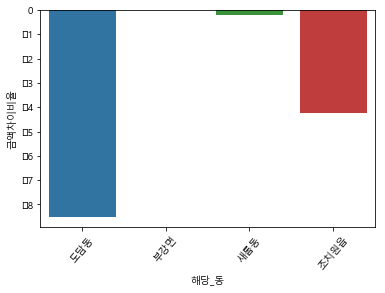

In [81]:
office_price_final_loc = office_price_final.groupby('해당_동')['금액차이비율'].mean().reset_index()
sns.barplot(office_price_final_loc['해당_동'], office_price_final_loc['금액차이비율'])
plt.xticks(rotation = 50)

In [82]:
first = office_price_diff[office_price_diff['first_last'] == 'first']
first = first[first['해당_동'] == '도담동']
last = office_price_diff[office_price_diff['first_last'] == 'last']
last = last[last['해당_동'] == '도담동']
last['금액'].sum() - first['금액'].sum() 

-55638449.46289027

## 오피스 전월세 가격추이

In [83]:
office_rent_dep = []
for i in office_rent['보증금(만원)'] :
    office_rent_dep.append(i.replace(',',''))
office_rent['보증금(만원)'] = office_rent_dep
office_rent['보증금(만원)'] = office_rent['보증금(만원)'].astype('int')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

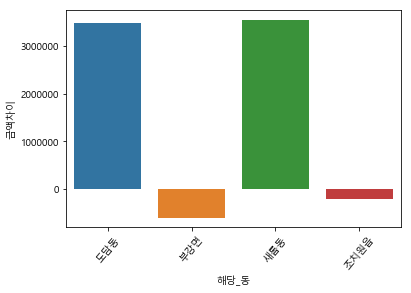

In [84]:
rent_price = []
for i in range(office_rent.shape[0]) :
    if office_rent['계약년월'][i] <= 202009 :
        if office_rent['전월세구분'][i] == '월세' :
            rent_price.append(office_rent['월세(만원)'][i]*12*25 + office_rent['보증금(만원)'][i])
        else :
            rent_price.append(office_rent['보증금(만원)'][i])
    else :
        if office_rent['전월세구분'][i] == '월세' :
            rent_price.append(office_rent['월세(만원)'][i]*12*40 + office_rent['보증금(만원)'][i])
        else :
            rent_price.append(office_rent['보증금(만원)'][i])
office_rent['책정금액'] = rent_price
office_rent['층'] = office_rent['층'].astype('str')
office_rent['단지명_층'] = office_rent['단지명'] + ' ' + office_rent['층'] +'층'
office_rent['전용면적당_가격'] = office_rent['책정금액'] * 10000 / office_rent['전용면적(㎡)'] * 3.3
office_rent_diff = office_rent.groupby('단지명_층')[['전용면적당_가격','ADM_DR_NM']].agg(['first','last']).stack().reset_index()
office_rent_diff.columns = ['단지명_층','first_last','금액','해당_동']
name = []
price_diff = []
location = []
per = []
for i in range(office_rent_diff.shape[0]-1) :
    if office_rent_diff['단지명_층'][i] == office_rent_diff['단지명_층'][i+1] :
        name.append(office_rent_diff['단지명_층'][i])
        price_diff.append(office_rent_diff['금액'][i+1] - office_rent_diff['금액'][i])
        location.append(office_rent_diff['해당_동'][i])
        per.append(100 * (office_rent_diff['금액'][i+1] - office_rent_diff['금액'][i])/office_rent_diff['금액'][i])
        
office_rent_final = pd.DataFrame({'단지명_층' : name,
              '해당_동' : location,
            '금액차이' : price_diff,
            '금액차이비율' : per})
        
office_rent_final_loc = office_rent_final.groupby('해당_동')['금액차이'].mean().reset_index()
sns.barplot(office_rent_final_loc['해당_동'], office_rent_final_loc['금액차이'])
plt.xticks(rotation = 50)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

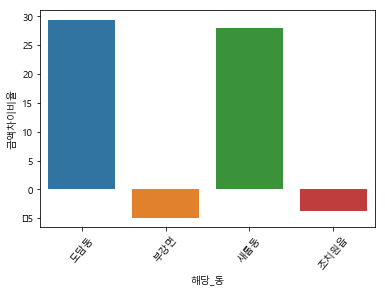

In [85]:
office_rent_final_loc = office_rent_final.groupby('해당_동')['금액차이비율'].mean().reset_index()
sns.barplot(office_rent_final_loc['해당_동'], office_rent_final_loc['금액차이비율'])
plt.xticks(rotation = 50)

## 단독 다가구 매매

In [86]:
dan_price_price = []
for i in dan_price['거래금액(만원)'] :
    dan_price_price.append(i.replace(',',''))
dan_price['거래금액(만원)'] = dan_price_price
dan_price['거래금액(만원)'] = dan_price['거래금액(만원)'].astype('int')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

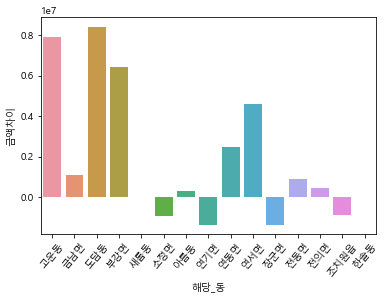

In [87]:
dan_price['X.1'] = dan_price['X.1'].astype('str')
dan_price['Y.1'] = dan_price['Y.1'].astype('str')
dan_price['X_Y_joined'] = dan_price['X.1'] + ' ' + dan_price['Y.1']
dan_price['전용면적당_가격'] = dan_price['거래금액(만원)'] * 10000 / dan_price['연면적(㎡)'] * 3.3
dan_price_diff = dan_price.groupby('X_Y_joined')[['전용면적당_가격','ADM_DR_NM']].agg(['first','last']).stack().reset_index()
dan_price_diff.columns = ['고유주소','first_last','금액','해당_동']
name = []
price_diff = []
location = []
per = []
for i in range(dan_price_diff.shape[0]-1) :
    if dan_price_diff['고유주소'][i] == dan_price_diff['고유주소'][i+1] :
        name.append(dan_price_diff['고유주소'][i])
        price_diff.append(dan_price_diff['금액'][i+1] - dan_price_diff['금액'][i])
        location.append(dan_price_diff['해당_동'][i])
        per.append(100 * (dan_price_diff['금액'][i+1] - dan_price_diff['금액'][i])/dan_price_diff['금액'][i])
        
dan_price_final = pd.DataFrame({'단지명_층' : name,
              '해당_동' : location,
            '금액차이' : price_diff,
            '금액차이비율' : per})
        
dan_price_final_loc = dan_price_final.groupby('해당_동')['금액차이'].mean().reset_index()
sns.barplot(dan_price_final_loc['해당_동'], dan_price_final_loc['금액차이'])
plt.xticks(rotation = 50)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

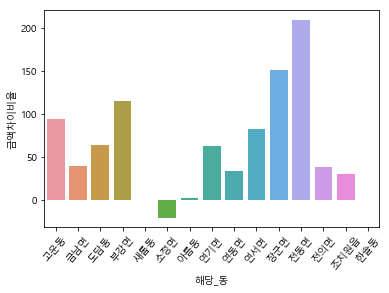

In [88]:
dan_price_final_loc = dan_price_final.groupby('해당_동')['금액차이비율'].mean().reset_index()
sns.barplot(dan_price_final_loc['해당_동'], dan_price_final_loc['금액차이비율'])
plt.xticks(rotation = 50)

## 단독다가구 전월세

In [89]:
dan_rent_dep = []
for i in dan_rent['보증금(만원)'] :
    dan_rent_dep.append(i.replace(',',''))
dan_rent['보증금(만원)'] = dan_rent_dep
dan_rent['보증금(만원)'] = dan_rent['보증금(만원)'].astype('int')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

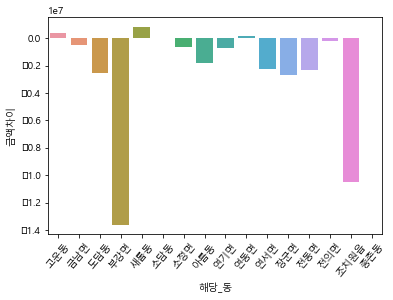

In [90]:
rent_price = []
for i in range(dan_rent.shape[0]) :
    if dan_rent['계약년월'][i] <= 202009 :
        if dan_rent['전월세구분'][i] == '월세' :
            rent_price.append(dan_rent['월세(만원)'][i]*12*25 + dan_rent['보증금(만원)'][i])
        else :
            rent_price.append(dan_rent['보증금(만원)'][i])
    else :
        if dan_rent['전월세구분'][i] == '월세' :
            rent_price.append(dan_rent['월세(만원)'][i]*12*40 + dan_rent['보증금(만원)'][i])
        else :
            rent_price.append(dan_rent['보증금(만원)'][i])
dan_rent['책정금액'] = rent_price
dan_rent['X.1'] = dan_rent['X.1'].astype('str')
dan_rent['Y.1'] = dan_rent['Y.1'].astype('str')
dan_rent['X_Y_joined'] = dan_rent['X.1'] + ' ' + dan_rent['Y.1']
dan_rent['전용면적당_가격'] = dan_rent['책정금액'] * 10000 / dan_rent['계약면적(㎡)'] * 3.3
dan_rent_diff = dan_rent.groupby('X_Y_joined')[['전용면적당_가격','ADM_DR_NM']].agg(['first','last']).stack().reset_index()
dan_rent_diff.columns = ['고유주소','first_last','금액','해당_동']
name = []
price_diff = []
location = []
per = []
for i in range(dan_rent_diff.shape[0]-1) :
    if dan_rent_diff['고유주소'][i] == dan_rent_diff['고유주소'][i+1] :
        name.append(dan_rent_diff['고유주소'][i])
        price_diff.append(dan_rent_diff['금액'][i+1] - dan_rent_diff['금액'][i])
        location.append(dan_rent_diff['해당_동'][i])
        per.append(100 * (dan_rent_diff['금액'][i+1] - dan_rent_diff['금액'][i])/dan_rent_diff['금액'][i])
        
dan_rent_final = pd.DataFrame({'고유주소' : name,
              '해당_동' : location,
            '금액차이' : price_diff,
            '금액차이비율' : per})
        
dan_rent_final_loc = dan_rent_final.groupby('해당_동')['금액차이'].mean().reset_index()
sns.barplot(dan_rent_final_loc['해당_동'], dan_rent_final_loc['금액차이'])
plt.xticks(rotation = 50)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

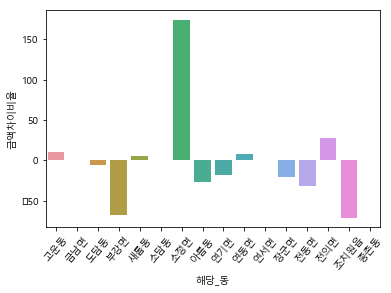

In [91]:
dan_rent_final_loc = dan_rent_final.groupby('해당_동')['금액차이비율'].mean().reset_index()
sns.barplot(dan_rent_final_loc['해당_동'], dan_rent_final_loc['금액차이비율'])
plt.xticks(rotation = 50)

## 아파트 분양권

In [92]:
apt_lot_dep = []
for i in apt_lot['거래금액(만원)'] :
    apt_lot_dep.append(i.replace(',',''))
apt_lot['거래금액(만원)'] = apt_lot_dep
apt_lot['거래금액(만원)'] = apt_lot['거래금액(만원)'].astype('int')

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

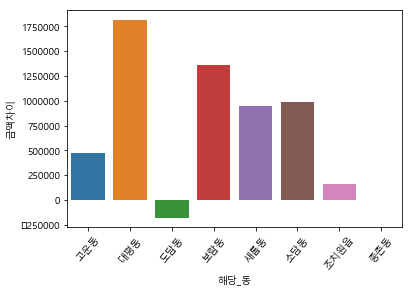

In [93]:
apt_lot['층'] = apt_lot['층'].astype('str')
apt_lot['단지명_층'] = apt_lot['단지명'] + ' ' + apt_lot['층'] +'층'
apt_lot['전용면적당_가격'] = apt_lot['거래금액(만원)'] * 10000 / apt_lot['전용면적(㎡)'] * 3.3
apt_lot_diff = apt_lot.groupby('단지명_층')[['전용면적당_가격','ADM_DR_NM']].agg(['first','last']).stack().reset_index()
apt_lot_diff.columns = ['단지명_층','firt_last','금액','해당_동']
name = []
price_diff = []
location = []
per = []
for i in range(apt_lot_diff.shape[0]-1) :
    if apt_lot_diff['단지명_층'][i] == apt_lot_diff['단지명_층'][i+1] :
        name.append(apt_lot_diff['단지명_층'][i])
        price_diff.append(apt_lot_diff['금액'][i+1] - apt_lot_diff['금액'][i])
        location.append(apt_lot_diff['해당_동'][i])
        per.append(100 * (apt_lot_diff['금액'][i+1] - apt_lot_diff['금액'][i])/apt_lot_diff['금액'][i])
        
apt_lot_final = pd.DataFrame({'단지명_층' : name,
              '해당_동' : location,
            '금액차이' : price_diff,
            '금액차이비율' : per})
        
apt_lot_final_loc = apt_lot_final.groupby('해당_동')['금액차이'].mean().reset_index()
sns.barplot(apt_lot_final_loc['해당_동'], apt_lot_final_loc['금액차이'])
plt.xticks(rotation = 50)


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

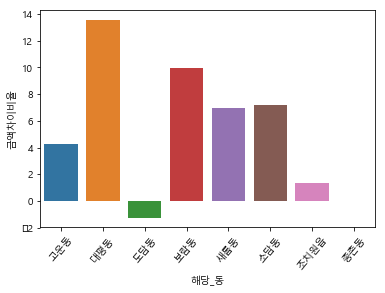

In [94]:
apt_lot_final_loc = apt_lot_final.groupby('해당_동')['금액차이비율'].mean().reset_index()
sns.barplot(apt_lot_final_loc['해당_동'], apt_lot_final_loc['금액차이비율'])
plt.xticks(rotation = 50)

# 총 부동산 지표

- 행정동 별 총 부동산 거래 금액에 항목별 비중에 따라 가중치를 해당 항목의 값에 곱하고 더해 세종시 내 해당 동의 부동산 가격의 상승 비율을 나타내는 지표

In [95]:
apt_price_sum = apt_price.groupby('ADM_DR_NM')['거래금액(만원)'].sum().reset_index()
apt_rent_sum = apt_rent.groupby('ADM_DR_NM')['책정금액'].sum().reset_index()
yunlip_price_sum = yunlip_price.groupby('ADM_DR_NM')['거래금액(만원)'].sum().reset_index()
yunlip_rent_sum = yunlip_rent.groupby('ADM_DR_NM')['책정금액'].sum().reset_index()
office_price_sum = office_price.groupby('ADM_DR_NM')['거래금액(만원)'].sum().reset_index()
office_rent_sum = office_rent.groupby('ADM_DR_NM')['책정금액'].sum().reset_index()
dan_price_sum = dan_price.groupby('ADM_DR_NM')['거래금액(만원)'].sum().reset_index()
dan_rent_sum = dan_rent.groupby('ADM_DR_NM')['책정금액'].sum().reset_index()
apt_lot_sum = apt_lot.groupby('ADM_DR_NM')['거래금액(만원)'].sum().reset_index()

In [96]:
apt_price_sum.columns = ['해당동','총금액']
apt_rent_sum.columns = ['해당동','총금액']
yunlip_price_sum.columns = ['해당동','총금액']
yunlip_rent_sum.columns = ['해당동','총금액']
office_price_sum.columns = ['해당동','총금액']
office_rent_sum.columns = ['해당동','총금액']
dan_price_sum.columns = ['해당동','총금액']
dan_rent_sum.columns = ['해당동','총금액']
apt_lot_sum.columns = ['해당동','총금액']

dfs = [apt_price_sum,apt_rent_sum,yunlip_price_sum,yunlip_rent_sum,office_price_sum,office_rent_sum,dan_price_sum, dan_rent_sum, apt_lot_sum]

In [97]:
sum_of_prices = []
for i in dfs :
    sum_of_prices.append(i['총금액'].sum(axis = 0))

In [98]:
import numpy as np
total_sum = np.array(sum_of_prices).sum()
estate_cat = ['apt_price','apt_rent','yunlip_price','yunlip_rent','office_price','office_rent','dan_price','dan_rent','apt_lot']
estate_ratio = pd.DataFrame({'부동산_종류' : estate_cat,
             '비율' : sum_of_prices / total_sum})

final_loc_list = [apt_price_final_loc,apt_rent_final_loc,yunlip_price_final_loc,yunlip_rent_final_loc,office_price_final_loc,office_price_final_loc, dan_price_final_loc, dan_rent_final_loc, apt_lot_final_loc]

In [100]:
estate_ratio_ = estate_ratio.copy()
estate_ratio_['부동산_종류'] = ['아파트_매매','아파트_전월세','연립다세대_매매','연립다세대_전월세','오피스텔_매매','오피스텔_전월세','단독다가구_매매','단독다가구_전월세','아파트_분양권']

In [101]:
estate_ratio_

,부동산_종류,비율
0,아파트_매매,0.452692
1,아파트_전월세,0.348245
2,연립다세대_매매,0.002593
3,연립다세대_전월세,0.001867
4,오피스텔_매매,0.001687
5,오피스텔_전월세,0.006277
6,단독다가구_매매,0.022661
7,단독다가구_전월세,0.016574
8,아파트_분양권,0.147405


In [49]:
for i in range(len(final_loc_list)-1) :
    if i == 0 :
        merged = pd.merge(final_loc_list[i],final_loc_list[i+1], on = '해당_동', how = 'left')
    else :
        merged = pd.merge(merged, final_loc_list[i+1], on = '해당_동', how = 'left')

merged.columns = ['동이름','아파트_매매_면적당_상승률','아파트_전월세_면적당_상승률','연립다세대_매매_면적당_상승률','연립다세대_전월세_면적당_상승률','오피스텔_매매_면적당_상승률','오피스텔_전월세_면적당_상승률','단독다가구_매매_면적당_상승률','단독다가구_전월세_면적당_상승률','아파트_분양권면적당_상승률']

merged = merged.fillna(0)

In [102]:
real_estate_indicator = []

for j in range(merged.shape[0]) :
    for i in range(len(estate_ratio)) :
        real_estate_indicator.append(estate_ratio['비율'][i] * merged.iloc[j,1:][i])
merged['부동산_지표'] = np.asarray(real_estate_indicator).reshape(19,9).sum(axis = 1)

In [349]:
merged.to_csv('./부동산_관련_자료/동별_부동산_추이_지표.csv', index = False)